<a href="https://colab.research.google.com/github/Jacquee18/machine-learning-models/blob/main/CUSTOMER_CHURN_PRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## 1. Introduction

For this study, we aim to achieve the following:

Identify and visualize the factors that contribute to customer churn.

Develop a prediction model that can classify whether a customer is likely to churn or not. Ideally, this model will also provide a probability score for each customer, which will help customer service teams to prioritize their efforts to prevent churn.

In summary, our goal is to understand the causes of customer churn, and to develop a tool that can help businesses to identify and retain their most valuable customers.

2. Data Set Review & Preparation
In this section, we will review and prepare the dataset for our analysis. Specifically, we will:

Explore the structure and content of the dataset, to understand the input space and the potential challenges and opportunities it presents.

Prepare the dataset for exploratory and predictive tasks, by cleaning and transforming the data as needed. This may involve handling missing values, dealing with outliers, and encoding categorical variables.

By the end of this section, we should have a well-structured and ready-to-use dataset that will support our further analysis and modeling efforts.

In [1]:
## IMPORTING REQUIRED LIBRARIES
import numpy as np
import pandas as pd
import pickle

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
# Read the data frame
df = pd.read_csv('Churn_Modelling.csv')
df.shape

(10000, 14)

In [3]:
# Check columns list and missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Well isn't that a rare find; no missing values!

In [4]:
# Get unique count for each variable
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [5]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [6]:
# Review the top rows of what is left of the data frame
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


The data appears to be a snapshot of the customer's accounts at a particular point in time. However, this leaves several questions:

What date is the snapshot from, and how does this date affect the analysis?
Is it possible to obtain balances for multiple dates, to see how the data changes over time?
Why do some customers who have exited still have a balance in their account? Does this mean they have exited from a product but not the bank?
What does it mean to be an "active member", and are there different levels of activity? Would it be better to use transaction counts (credits and debits) instead?
Could a breakdown of the products that customers have bought provide more insights than just a count of products?
For this exercise, we will proceed with the modeling without considering the context or extraction process of the data. However, it is worth noting that understanding the context and data extraction process can provide valuable insights and potentially improve the results of the modeling process.

In [7]:
# Check variable data types
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 3. Exploratory Data Analysis


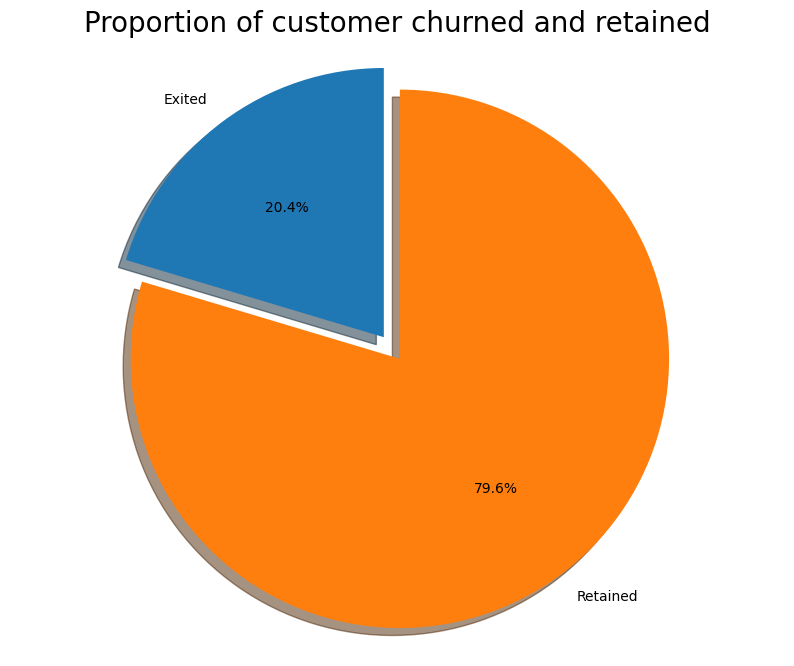

In [8]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

About 20% of the customers in our dataset have churned, so a baseline model could simply predict that 20% of all customers will churn. However, since this is a relatively small number, it is important for the model to have high accuracy in predicting this group of customers. Therefore, our focus should be on developing a model that can accurately identify the customers who are likely to churn, rather than just achieving overall high accuracy in predicting all customers. This will be of particular interest to the bank, as it will help them to target their retention efforts and prevent valuable customers from leaving.

<Axes: xlabel='IsActiveMember', ylabel='count'>

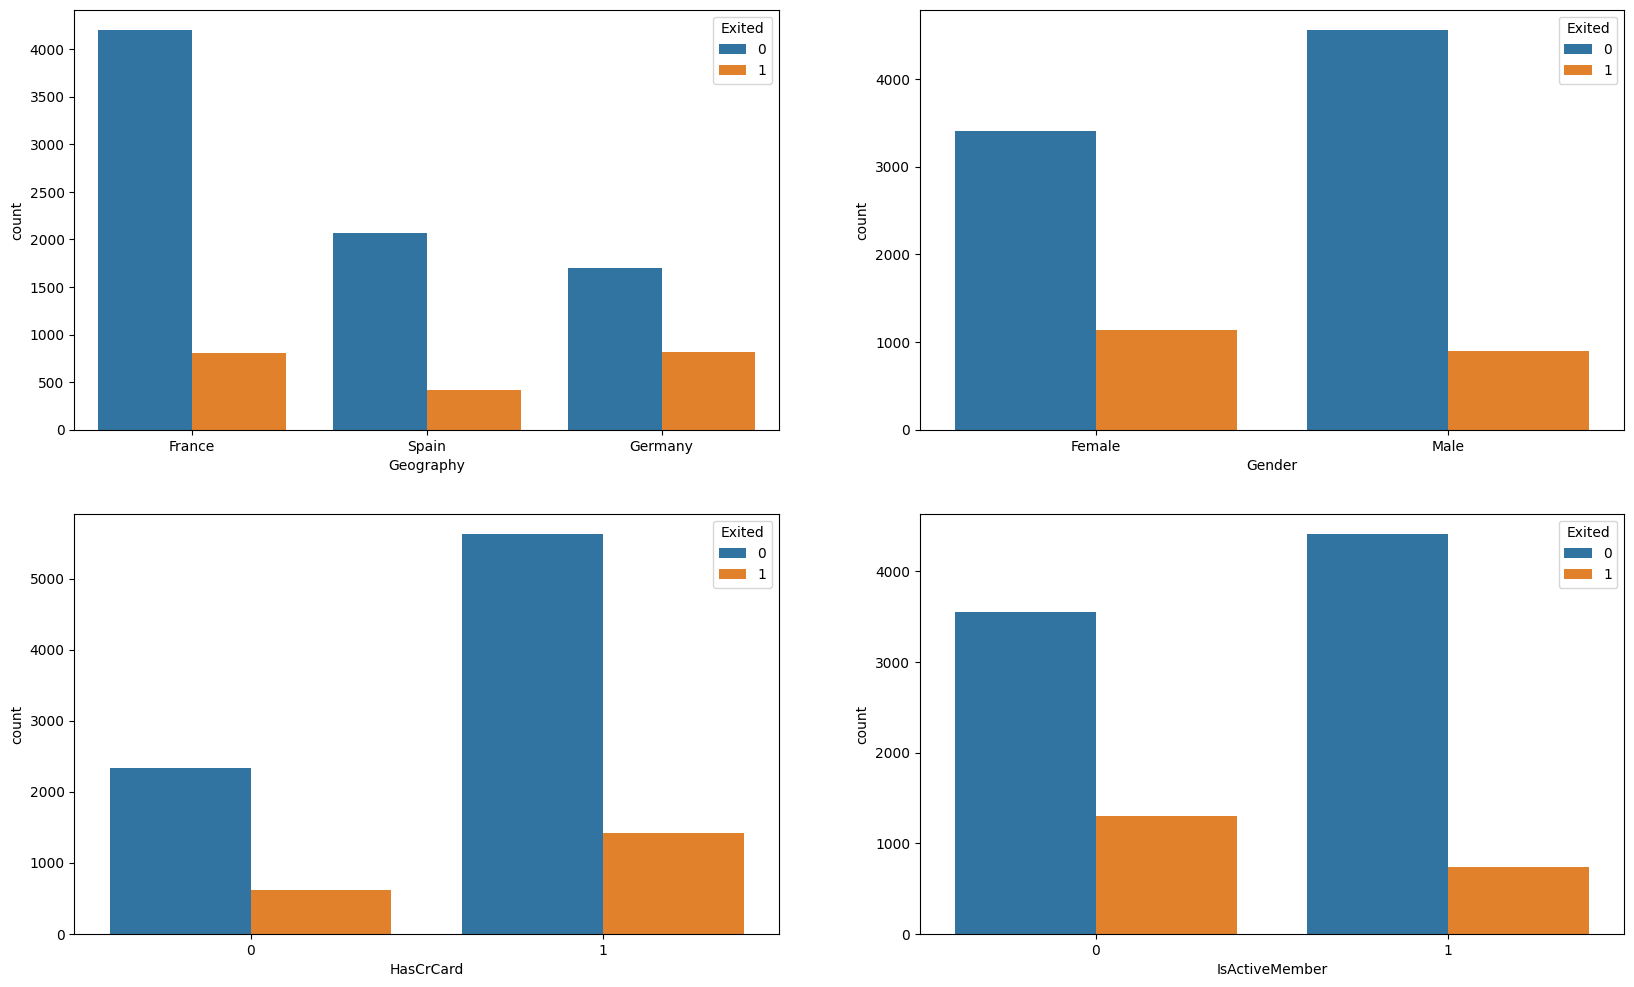

In [9]:
    # We first review the 'Status' relation with categorical variables
    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
    sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

The majority of the data comes from customers in France, but the proportion of churned customers is inversely related to the overall population of customers, suggesting that the bank may have a problem retaining customers in areas where it has fewer clients.
Female customers are more likely to churn than male customers.
A significant number of customers who have churned were credit card holders, but since most of the customers have credit cards, this may be a coincidence.
Unsurprisingly, inactive members are more likely to churn, and the overall proportion of inactive members is high, indicating that the bank may need to implement a program to encourage these customers to become active. This could potentially reduce the overall churn rate.

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

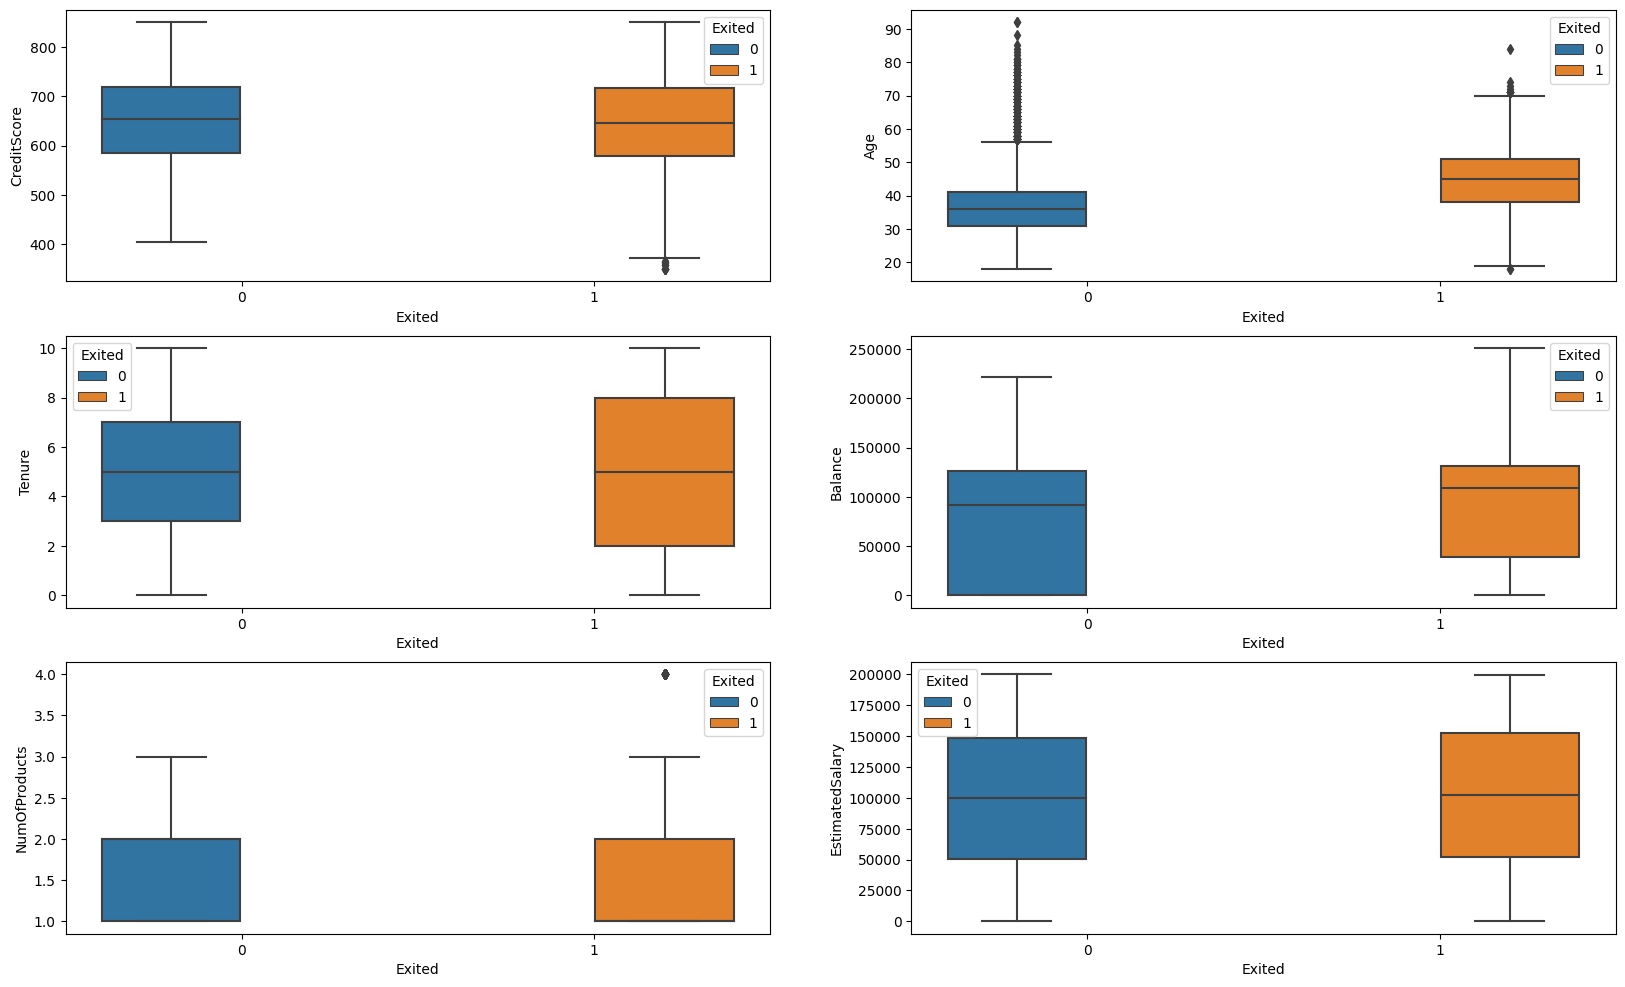

In [10]:
    # Relations based on the continuous data attributes
    fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
    sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
    sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
    sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
    sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
    sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
    sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

After reviewing the data, we have observed the following:

There is no significant difference in the credit score distribution between retained and churned customers.
Older customers are more likely to churn than younger ones, indicating a potential difference in service preferences between different age groups. The bank may need to review its target market or retention strategy to address this.
Customers with extreme tenure (either very short or very long) are more likely to churn than those with average tenure.
The bank is losing customers with significant bank balances, which could impact its available capital for lending.
Neither the product nor the salary has a significant effect on the likelihood of churn.

## 4. Feature engineering
We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

In [11]:
# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.preprocessing import LabelEncoder

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [12]:
le = LabelEncoder()
df['Geography'] = le.fit_transform(df['Geography'])
df['Gender'] = le.fit_transform(df['Gender'])


df.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0
5,645,2,1,44,8,113755.78,2,1,0,149756.71,1
6,822,0,1,50,7,0.00,2,1,1,10062.80,0
7,376,1,0,29,4,115046.74,4,1,0,119346.88,1
8,501,0,1,44,4,142051.07,2,0,1,74940.50,0
9,684,0,1,27,2,134603.88,1,1,1,71725.73,0


In [13]:
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(y_test))

8000
2000


In [14]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,686,0,1,32,6,0.00,2,1,1,179093.26
1561,632,1,1,42,4,119624.60,2,1,1,195978.86
1670,559,2,1,24,3,114739.92,1,1,0,85891.02
6087,561,0,0,27,9,135637.00,1,1,0,153080.40
6669,517,0,1,56,9,142147.32,1,0,0,39488.04


In [15]:
X_train.drop('Geography',axis=1)
X_train.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,686,0,1,32,6,0.00,2,1,1,179093.26
1561,632,1,1,42,4,119624.60,2,1,1,195978.86
1670,559,2,1,24,3,114739.92,1,1,0,85891.02
6087,561,0,0,27,9,135637.00,1,1,0,153080.40
6669,517,0,1,56,9,142147.32,1,0,0,39488.04
5933,569,0,1,41,4,120243.49,1,1,0,163150.03
8829,683,0,0,40,1,0.00,2,0,0,75762.00
7945,759,0,0,45,8,0.00,2,1,1,99251.24
3508,426,0,0,34,3,0.00,2,1,1,61230.83
2002,601,0,1,74,2,0.00,2,0,1,51554.58


In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(y_test))

8000
2000


In [17]:
# Train the random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model on the testing set
accuracy = rf.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8645


In [18]:
import pickle
pickle.dump(rf, open('Random_Forest_Model2.pkl', 'wb'))

In [19]:
from google.colab import files
files.download('./Random_Forest_Model2.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>